In [1]:
"""
The algorithm needs a little more tweaking.
We should look into DCEC? An advancement of DEC that uses Convolutional Layers instead of FC network for compression and decompression

HOWEVER, we will first look at how this algorithm performs on a different dataset.
Mainly, a dataset that has better image resolution, and ultimately, a video dataset divided into frames.
The algorithm will output a directory with divided frames. We will rename all the images just to make sure the ordering is what we expect

"""

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from sklearn.cluster import KMeans



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [38]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

'/home/jbang36/eva/data/ua_detrac/small-data'

In [39]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

/home/jbang36/eva/data/ua_detrac/small-data
Length of file_names 10421
/home/jbang36/eva/data/ua_detrac/small-data/MVI_20011/img00001.jpg


In [40]:
# split the training and test data

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

In [41]:
print(n_samples)
print(len(train_x))
print(len(test_x))

10421
8336
2085


(45, 80)


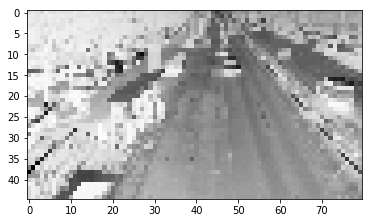

In [42]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

plt.imshow(train_x[image_index], cmap='Greys')

In [43]:
n_samples, width, height = image_table.shape
train_x = train_x.reshape(-1, width*height).astype('float32')
test_x = test_x.reshape(-1, width*height).astype('float32')

# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [44]:
print(train_x.shape)
print(test_x.shape)

print(train_x[:3])
print("---------------")
print(test_x[:3])

(8336, 3600)
(2085, 3600)
[[0.25490198 0.2627451  0.23529412 ... 0.50980395 0.5019608  0.5764706 ]
 [0.2509804  0.24313726 0.24705882 ... 0.5058824  0.5137255  0.5882353 ]
 [0.25882354 0.24705882 0.23921569 ... 0.5019608  0.52156866 0.5686275 ]]
---------------
[[0.31764707 0.28235295 0.3019608  ... 0.5568628  0.59607846 0.63529414]
 [0.3254902  0.28235295 0.30980393 ... 0.5568628  0.6156863  0.60784316]
 [0.30980393 0.2901961  0.3137255  ... 0.54509807 0.61960787 0.61960787]]


In [45]:
# this is our input placeholder
input_img = Input(shape=(3600,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(3600)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.summary()

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3600)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               1800500   
_________________________________________________________________
dense_18 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_19 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_21 (Dense)             (None, 2000)              22000     
_________________________________________________________________
dense_22 (Dense)             (None, 500)               1000500   
__________

In [46]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=70, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Train on 8336 samples, validate on 2085 samples
Epoch 1/70
8336/8336 [==============================] - 1s 139us/step - loss: 0.2271 - val_loss: 0.0732
Epoch 2/70
8336/8336 [==============================] - 0s 56us/step - loss: 0.0613 - val_loss: 0.0279
Epoch 3/70
8336/8336 [==============================] - 0s 47us/step - loss: 0.0357 - val_loss: 0.0351
Epoch 4/70
8336/8336 [==============================] - 0s 56us/step - loss: 0.0339 - val_loss: 0.0250
Epoch 5/70
8336/8336 [==============================] - 0s 58us/step - loss: 0.0238 - val_loss: 0.0239
Epoch 6/70
8336/8336 [==============================] - 0s 57us/step - loss: 0.0231 - val_loss: 0.0232
Epoch 7/70
8336/8336 [==============================] - 0s 57us/step - loss: 0.0221 - val_loss: 0.0222
Epoch 8/70
8336/8336 [==============================] - 0s 55us/step - loss: 0.0214 - val_loss: 0.0219
Epoch 9/70
8336/8336 [==============================] - 0s 55us/step - loss: 0.0212 - val_loss: 0.0220
Epoch 10/70
8336/8336 [=

In [11]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([[1.0, 2.0], [1.0, 4.0], [1.0, 0.0],
               [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering 
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')
clustering.labels_


array([1, 1, 1, 0, 0, 0])

[[0.25490198 0.2627451  0.23529412 ... 0.50980395 0.5019608  0.5764706 ]
 [0.2509804  0.24313726 0.24705882 ... 0.5058824  0.5137255  0.5882353 ]
 [0.25882354 0.24705882 0.23921569 ... 0.5019608  0.52156866 0.5686275 ]]
------------------
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
------------------
[[0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]
 [0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]
 [0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]
 ...
 [0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]
 [0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]
 [0.27644774 0.24127868 0.25686225 ... 0.516495   0.52291673 0.54046595]]
-----------------
[[0.31764707 0.28235295 0.3019608  ... 0.5568628  0.59607846 0.63529414]
 [0.3254902  0.28235295 0.30980393 ... 0.5568628  0

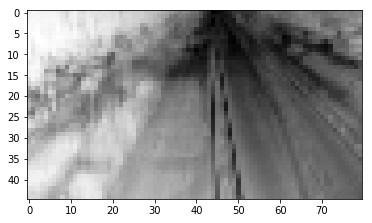

In [47]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

n_samples, width, height = image_table.shape
image_table_flattened = image_table.reshape(-1, width*height).astype('float32')
image_table_flattened /= 255.0

auto_encoded_train = encoder.predict(train_x)
auto_encoded_test = encoder.predict(test_x)

train_decoded = autoencoder.predict(train_x)
test_decoded = autoencoder.predict(test_x)
print(train_x[:3])
print("------------------")
print(auto_encoded_train)
print("------------------")
print(train_decoded[:10])
print("-----------------")
print(test_x[:3])
print("-----------------")
print(auto_encoded_test)
print("------------------")

images_compressed = encoder.predict(image_table_flattened)
print(images_compressed[:10])

fps = 20
ac = AgglomerativeClustering(n_clusters=len(images_compressed) // fps)

start_time = time.time()
ac.fit(images_compressed)
print("Time to fit ", n_samples, ": ", time.time() - start_time)
images_label = ac.labels_

print(min(images_label))
print(max(images_label))

import matplotlib.pyplot as plt
example = train_decoded[0]
example *= 255.0
example = example.astype('int32')
example = example.reshape(width, height)

plt.imshow(example, cmap='Greys')

In [13]:
print(images_label)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [14]:
# Copy original data to the new clusters

from shutil import copyfile


home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-data', 'MVI_20011')
image_files = os.listdir(data_dir)
image_files.sort()

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')

cluster_max = max(images_label)

for i in range(cluster_max + 1):
    cluster_dir = os.path.join(cluster_dir_pre, str(i))
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    
for j in range(len(image_files)):
    src = os.path.join(data_dir, image_files[j])
    dst = os.path.join(cluster_dir_pre, str(images_label[j]), image_files[j])
    copyfile(src, dst)

    


32
42


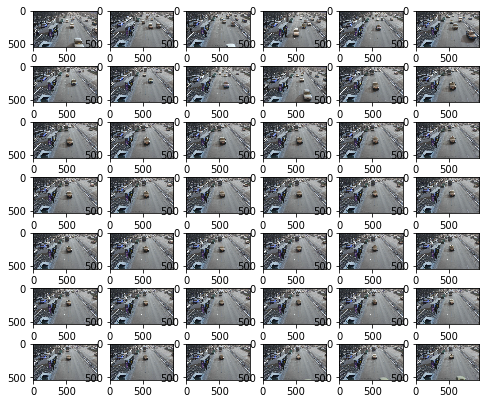

In [20]:
# UTIL: Plot the images that belong in the same cluster
# We will select 1 from each directory

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')
cluster_max = max(images_label)
print(cluster_max)

full_paths = []
for i in range(cluster_max + 1):
    cluster_dir = os.path.join(cluster_dir_pre, str(i))
    # Pick the first image from the directory
    image_files = os.listdir(cluster_dir)
    if i == 0:
        for j in range(10):
            full_paths.append(os.path.join(cluster_dir, image_files[j]))
    elif len(image_files) != 0:
        full_paths.append(os.path.join(cluster_dir, image_files[0]))
    
        

        
print(len(full_paths))
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(8, 8))
columns = 6
rows =(10 + cluster_max) // columns + 1


for idx, image in enumerate(full_paths):
    fig.add_subplot(rows, columns, idx + 1)
    a = cv2.imread(image)
    plt.imshow(a)
plt.show()
    
    


In [ ]:
# UTIL: Remove all the clusters and its data

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')
cluster_max = max(images_label)


for i in range(cluster_max + 1):
    cluster_dir = os.path.join(cluster_dir_pre, str(i))
    if os.path.exists(cluster_dir):
        shutil.rmtree(cluster_dir)
        
